# Project name: 'Customer churn prediction model'

# Project description: telecommunications

A telecom operator wants to learn how to predict customer churn. If it turns out that
the user plans to leave, he will be offered promotional codes and special conditions. The operator team assembled personal data about some clients, information about their tariffs and contracts.

# Target
Create a machine learning model that predicts customer churn, with an ROC-AUC greater than 0.85.

# Tasks
1. conduct initial research of datasets

* missing values
* value type
* distribution of values (presence of outliers)

2. consolidate datasets into a single table

3. conduct an analysis of customer outflow regarding the services provided

4. highlight the target feature

5. see feature correlation

* display matrix for initial viewing
* select columns with high and low dependency to remove

6. prepare the dataset for model training

* remove columns with high and low dependencies
* divide into samples
* carry out coding (ordinal for RandomForestClassifier and CatBoostClassifier
and OHE for LogisticRegression) and feature scaling when trained using Pipeline

7. write model code

* LogisticRegression
* RandomForestClassifier
* CatBoostClassifier

8. training models

* calculate ROC-AUC on the training model
* write conclusions
* select a model with a result greater than 0.85 (if this is not the case, return to feature preparation)

9. testing the selected model

* calculate accuracy
* build and analyze ROC-curve
* analyze the error matrix and the importance of signs
* interpret the result in words

10. write a report, make recommendations


### Importing libraries and data

In [1]:
# importing libraries for exploratory data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from phik.report import plot_correlation_matrix
from phik import report
import time
# importing modules for training models
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier, Pool, cv
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score, 
    balanced_accuracy_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    train_test_split
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    RobustScaler,
    PowerTransformer
)
from tqdm.notebook import trange, tqdm

*display the datasets

In [2]:
# let's read the datasets
try:
    contract = pd.read_csv('/datasets/contract_new.csv')
    internet_new = pd.read_csv('/datasets/internet_new.csv')
    personal = pd.read_csv('/datasets/personal_new.csv')
    phone_new = pd.read_csv('/datasets/phone_new.csv')

except:
    contract = pd.read_csv('C:/Users/hp/Documents/data_science/Data_science/Проекты/Дипломный проект/Телекоммуникации_классификация/contract_new.csv')
    internet_new = pd.read_csv('C:/Users/hp/Documents/data_science/Data_science/Проекты/Дипломный проект/Телекоммуникации_классификация/internet_new.csv')
    personal = pd.read_csv('C:/Users/hp/Documents/data_science/Data_science/Проекты/Дипломный проект/Телекоммуникации_классификация/personal_new.csv')
    phone_new = pd.read_csv('C:/Users/hp/Documents/data_science/Data_science/Проекты/Дипломный проект/Телекоммуникации_классификация/phone_new.csv')


### Primary data analysis

#### Contract table

In [3]:
# display the contract on the screen
display(contract.head(5))
print(contract.info())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None


In [4]:
# set the reporting period
print(contract['BeginDate'].min())
print(contract['BeginDate'].max())

2013-10-01
2020-02-01


There are 7043 rows in the contract dataset. BeginDate, EndDate must be cast to datetime type; TotalCharges to type float. The reporting period is approximately 6 years from 10/01/2013 to 02/01/2020. Dates in the BeginDate column start from the 01st day, i.e. contracts are concluded on the 01st day of the month.

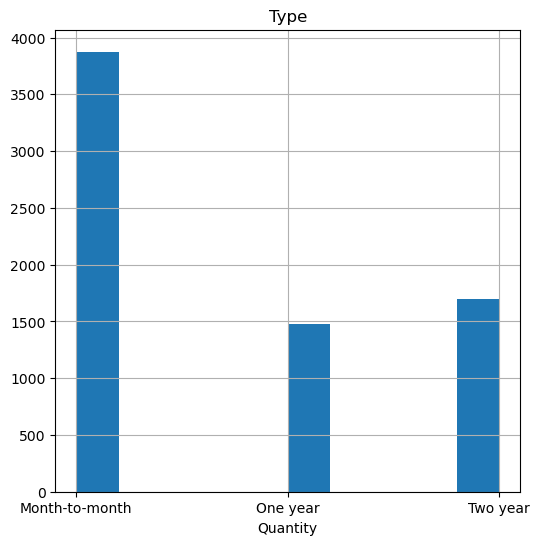

In [5]:
# types of contracts in the Type column
contract['Type'].hist(figsize=(6, 6))
plt.xlabel('Quantity')
plt.title('Type');

The largest number of contract types are for Month-to-month

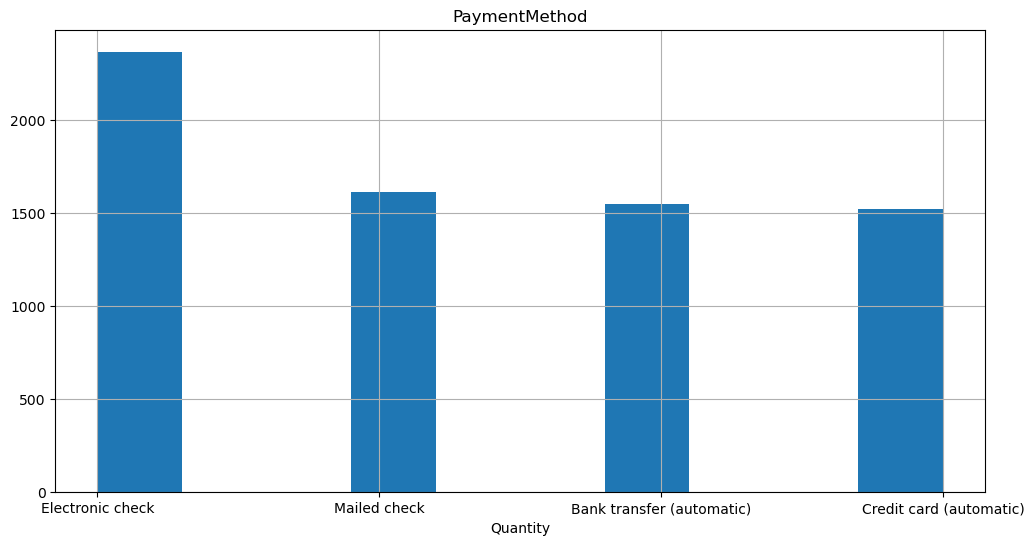

In [6]:
# PaymentMethod column payment types
contract['PaymentMethod'].hist(figsize=(12, 6))
plt.xlabel('Quantity')
plt.title('PaymentMethod');

Electronic check payment occurs more often than other types. Other types of payments are distributed evenly.

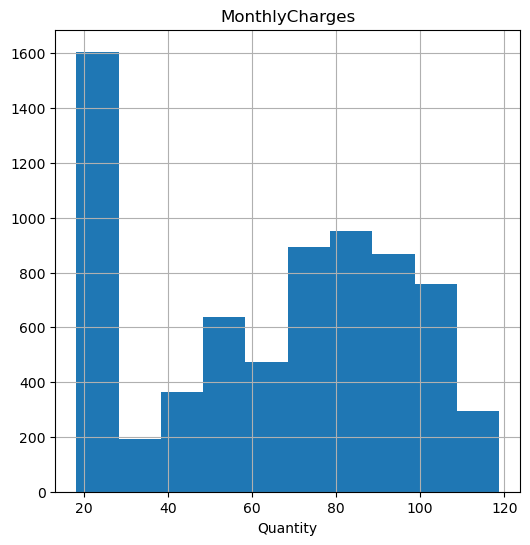

In [7]:
# let's look at the MonthlyChsrges column
contract.hist(figsize=(6,6), bins=10)
plt.xlabel('Quantity');

MonthlyCharges has a large number of different values, there are outliers in the region < 20. Let's examine this column more carefully.

In [8]:
# let's look at the table slice MonthlyCharges<20
display(contract[contract['MonthlyCharges'] <= 20])

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
11,7469-LKBCI,2018-10-01,No,Two year,No,Credit card (automatic),18.95,312.3
21,1680-VDCWW,2019-02-01,No,One year,No,Bank transfer (automatic),19.80,237.6
88,2796-NNUFI,2016-04-01,No,Two year,Yes,Mailed check,19.95,917.7
101,3679-XASPY,2020-01-01,No,Month-to-month,No,Electronic check,19.45,19.45
109,2848-YXSMW,2014-02-01,2018-06-01,Two year,No,Credit card (automatic),19.40,1008.8
...,...,...,...,...,...,...,...,...
6951,9588-YRFHY,2016-01-01,No,Two year,Yes,Credit card (automatic),19.90,1023.85
6954,9364-YKUVW,2018-11-01,No,Month-to-month,Yes,Mailed check,19.80,297.0
6958,3078-ZKNTS,2019-01-01,No,Two year,Yes,Bank transfer (automatic),19.75,272.16
7005,9347-AERRL,2018-03-01,2019-12-01,One year,No,Credit card (automatic),19.30,433.67


In [9]:
# change the data type for BeginDate to datetime
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y-%m-%dT%H:%M:%S')
display(contract.head(5))
contract.info()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB


In [10]:
# slice of the contract table based on the values of the TotalCharges column == " "
display(contract[contract['TotalCharges']==" "])

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


When trying to change the data type of the TotalCharges column from object to float64, we received an error with the following description: "could not convert string to float: '' ". Indicates that there are empty cells in the column. We made a table slice - indeed there are empty cells and the gaps refer to clients whose BeginDate is 2020-02-01, that is, these are new clients. Replace empty cells with 0

In [11]:
# replace the '' values in TotalCharges with 0 and convert all values to float
contract['TotalCharges'] = contract['TotalCharges'].replace(' ', '0')
contract['TotalCharges'] = contract['TotalCharges'].astype(float)
display(contract.sort_values(by=['TotalCharges']).head(5))
print(contract.info())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,0.0
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,0.0
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,0.0
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,0.0
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 440.3+ KB
None


Before changing the data type in the EndDate column, let’s display it on the screen and see what values ​​are present in this column

In [12]:
# display unique EndDate values
contract['EndDate'].unique()

array(['No', '2017-05-01', '2016-03-01', '2018-09-01', '2018-11-01',
       '2018-12-01', '2019-08-01', '2018-07-01', '2017-09-01',
       '2015-09-01', '2016-07-01', '2016-06-01', '2018-03-01',
       '2019-02-01', '2018-06-01', '2019-06-01', '2020-01-01',
       '2019-11-01', '2016-09-01', '2015-06-01', '2016-12-01',
       '2019-05-01', '2019-04-01', '2017-06-01', '2017-08-01',
       '2018-04-01', '2018-08-01', '2018-02-01', '2019-07-01',
       '2015-12-01', '2014-06-01', '2018-10-01', '2019-01-01',
       '2017-07-01', '2017-12-01', '2018-05-01', '2015-11-01',
       '2019-10-01', '2019-03-01', '2016-02-01', '2016-10-01',
       '2018-01-01', '2017-11-01', '2015-10-01', '2019-12-01',
       '2015-07-01', '2017-04-01', '2015-02-01', '2017-03-01',
       '2016-05-01', '2016-11-01', '2015-08-01', '2019-09-01',
       '2017-10-01', '2017-02-01', '2016-08-01', '2016-04-01',
       '2015-05-01', '2014-09-01', '2014-10-01', '2017-01-01',
       '2015-03-01', '2015-01-01', '2016-01-01', 

In the EndDate column we see the following values - dates for those clients who left and No for those who remain

Before changing the type of column values, we will perform the following manipulations:
1. Let's add a customer_loss column to the table with the value 1-left, 0-remained. Let's put it based on the data in the EndDate column: No(EndDate)=0(customer_loss); dates(EndDate)=1(customer_loss). The customer_loss column is a column with target characteristics;
2. The values No(EndDate) will be replaced by the date of report generation - 2020-02-01
3. Let's change the EndDate data type to datetime

In [13]:
# add the customer_loss column to the contract table 1-left, 0-not left based on the EndDate column
# if EndDate is No - did not leave (0), if there is an end date - left (1)
contract['customer_loss'] = (contract['EndDate'] != 'No').astype(int)
display(contract.head())
# let's check that the customer_loss column is filled in correctly
print('0 в customer_loss =', contract['customer_loss']. value_counts ()[0])
print('No в BeginDate =', contract['EndDate']. value_counts ()['No'])

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,customer_loss
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,0


0 в customer_loss = 5942
No в BeginDate = 5942


In [14]:
# transform the EndDate column: replace No with 2020-02-01; change the data type from object to datetime
contract['EndDate'] = pd.to_datetime(contract['EndDate'].replace('No', '2020-02-01'), format='%Y-%m-%dT')

display(contract.head())
print('EndDate Column Data Type -', contract.dtypes['EndDate'])

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,customer_loss
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0


EndDate Column Data Type - datetime64[ns]


To conduct a research analysis, we will add a days_total column, which will contain how long has passed since the company began working with each client. The calculation formula is as follows: days_total=EndDate-BeginDate.

In [15]:
# add a column days_total, which will contain the number of days from the start 
## of the company’s work with the client until the end of the contract
# or if the client has not left, then until 2020-02-01 (date of report generation)
contract['days_total'] = (contract['EndDate'] - contract['BeginDate']).dt.days
display(contract.head())
print(contract.info())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,customer_loss,days_total
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,153


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   customer_loss     7043 non-null   int32         
 9   days_total        7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int32(1), int64(1), object(4)
memory usage: 522.9+ KB
None


In [16]:
# let's look at the contract statistics
contract.describe()

,MonthlyCharges,TotalCharges,customer_loss,days_total
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2115.312885,0.156325,898.555729
std,30.090047,2112.742814,0.363189,683.130510
min,18.250000,0.000000,0.000000,0.000000
25%,35.500000,436.750000,0.000000,276.000000
50%,70.350000,1343.350000,0.000000,761.000000
75%,89.850000,3236.690000,0.000000,1461.000000
max,118.750000,9221.380000,1.000000,2314.000000


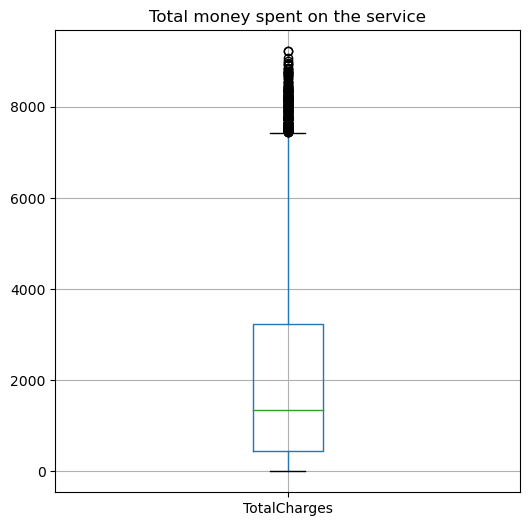

In [17]:
# let's look at emissions according to TotalCharges
contract.boxplot(column=['TotalCharges'], figsize=(6,6))
plt.title('Total money spent on the service')
plt.show()

In [18]:
# let's look at contracts with the total amount of money spent equal to 0 (TotalCharges=0)
display(contract.query('TotalCharges == 0'))
print('Number of lines', contract.query('TotalCharges == 0')['TotalCharges'].count())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,customer_loss,days_total
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,0.0,0,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,0.0,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,0.0,0,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,0.0,0,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,0.0,0,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,0.0,0,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,0.0,0,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,0.0,0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,0.0,0,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,0.0,0,0


Number of lines 11


The minimum amount of “total money spent on services” is 0 - normal, since these are contracts that were concluded on the date 2020-02-01, there are only 11 such contracts. Nothing will be done with these lines.

In [19]:
# display the top whisker on the TotalCharges screen
# upper whisker limit = (Q3-Q1)*1.5+Q3
display(contract.query('TotalCharges > 7436.6'))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,customer_loss,days_total
17,9959-WOFKT,2014-03-01,2020-02-01,Two year,No,Bank transfer (automatic),106.70,8257.51,0,2163
57,5067-XJQFU,2014-08-01,2020-02-01,One year,Yes,Electronic check,108.45,7730.32,0,2010
59,5954-BDFSG,2014-02-01,2020-02-01,Two year,Yes,Credit card (automatic),107.50,7740.00,0,2191
106,6728-DKUCO,2014-02-01,2020-02-01,One year,Yes,Electronic check,104.15,7498.80,0,2191
198,7255-SSFBC,2014-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),112.25,8324.46,0,2191
...,...,...,...,...,...,...,...,...,...,...
6859,3508-CFVZL,2014-03-01,2020-02-01,Two year,No,Mailed check,111.30,7902.30,0,2163
6910,0530-IJVDB,2014-04-01,2020-02-01,Two year,Yes,Electronic check,114.60,8182.44,0,2132
6913,8213-TAZPM,2014-05-01,2020-02-01,One year,Yes,Bank transfer (automatic),108.75,7728.86,0,2102
6992,0218-QNVAS,2014-03-01,2020-02-01,One year,No,Bank transfer (automatic),100.55,7638.78,0,2163


Minimum days 1826


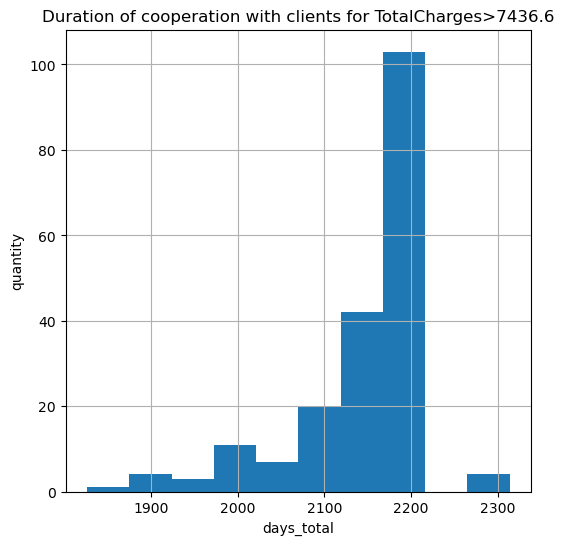

In [20]:
# distribution of the number of TotalCharges of the upper mustache by contract type (Type)
contract.query('TotalCharges > 7436.6')['days_total'].hist(figsize= (6, 6))
plt.title('Duration of cooperation with clients for TotalCharges>7436.6')
plt.xlabel('days_total')
plt.ylabel('quantity');
print('Minimum days', contract.query('TotalCharges > 7436.6')['days_total'].min())

The minimum number of days for the duration of contracts is 1826 days, i.e. approximately 5 years. Therefore, it is not surprising that TotalCharges has values of about 8000. Let’s not change anything in the upper tail; I think that the model should be able to work with tick data.

#### Table internet_new

In [21]:
# display internet_new
display(internet_new.head(5))
print(internet_new.info())

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None


There are 5517 rows in the internet_new dataset, perhaps not all clients use the Internet

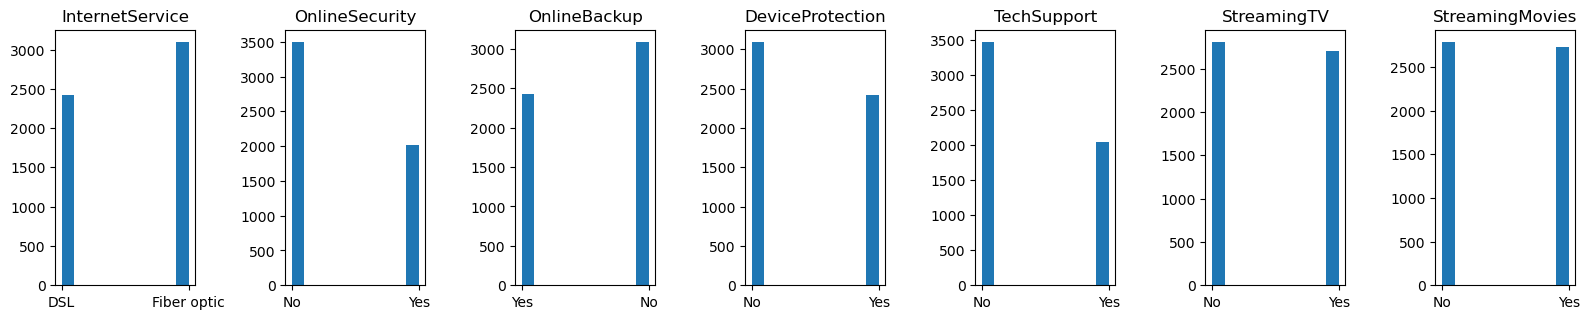

In [22]:
# distribution of data in internet_new columns
# row column count
df=internet_new
plt.figure(figsize=(16, 6))
numeric_names = ['InternetService'  , 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
                 'StreamingMovies']
counter = 0
numeric_len = len(numeric_names)
for feature in numeric_names:
    counter += 1
    plt.subplot(2, numeric_len, counter)
    plt.hist(internet_new[feature])
    plt.tight_layout()
    plt.title(feature)

We see a practically uniform distribution of classes in all columns except OnlineSecurity and TechSupport. More clients do not use OnlineSecurity and TechSupport services than use them.

#### Personal table

In [23]:
# display personal
display(personal.head(5))
print(personal.info())

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None


In [24]:
# replace the answers in the SeniorCitizen column with Yes(1) and No(0)
personal['SeniorCitizen'] = personal['SeniorCitizen'].replace({0 : 'No', 1 : 'Yes'})
display(personal.head())

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,No,Yes,No
1,5575-GNVDE,Male,No,No,No
2,3668-QPYBK,Male,No,No,No
3,7795-CFOCW,Male,No,No,No
4,9237-HQITU,Female,No,No,No


The dataset contains personal data such as gender, whether the client is a pensioner, married, and whether the client has dependent children. Number of rows - 7043 as in the contract dataset

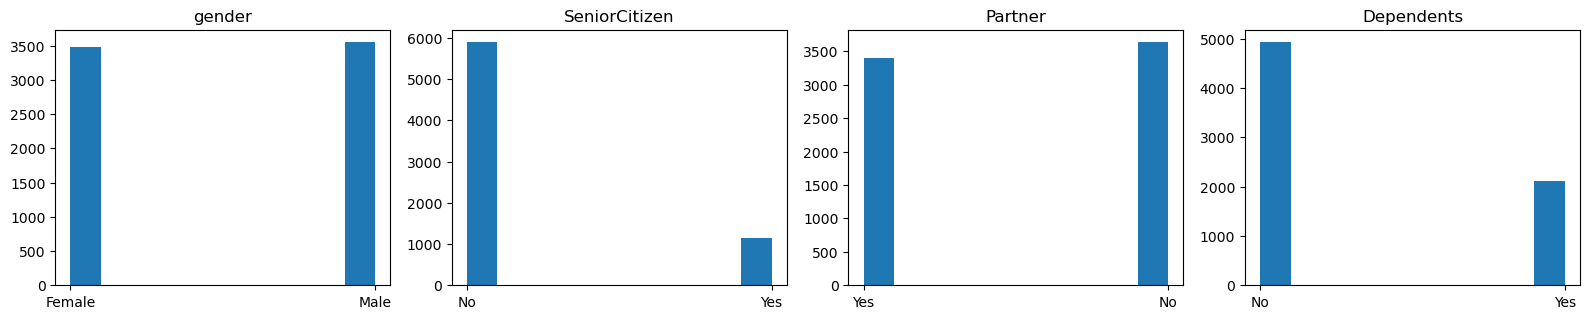

In [25]:
# distribution of data in personal columns
df=personal
plt.figure(figsize=(16, 6))
numeric_names = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']
counter = 0
numeric_len = len(numeric_names)
for feature in numeric_names:
    counter += 1
    plt.subplot(2, numeric_len, counter)
    plt.hist(df[feature])
    plt.tight_layout()
    plt.title(feature)

The distribution of data in gender and Partner is even, the share of clients of retirement age is very small, and clients with dependents are approximately two times less than clients without dependents.

#### Table phone_new

In [26]:
# display phon_new
display(phone_new.head(5))
print(phone_new.info())

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None


In the phone_new dataset there are 6360 fewer rows than in contract and more than internet_new and only 1 column answering the question whether the service uses the ability to connect a telephone set to several lines at the same time.

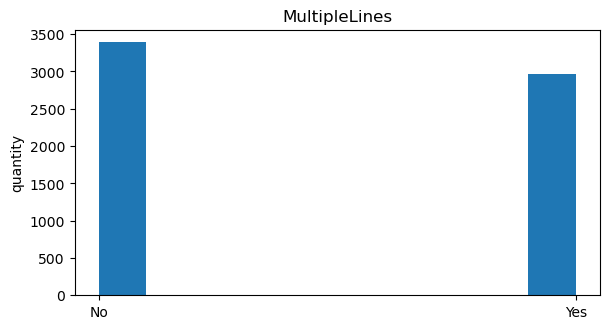

In [27]:
# распределение данных в столбцах phone_new
df=phone_new
plt.figure(figsize=(6, 6))
numeric_names = ['MultipleLines']
counter = 0
numeric_len = len(numeric_names)
for feature in numeric_names:
    counter += 1
    plt.subplot(2, numeric_len, counter)
    plt.hist(df[feature])
    plt.tight_layout()
    plt.title(feature)
    plt.ylabel('quantity')

We see an approximately uniform distribution of answers

Conclusion after the first meeting.
After getting acquainted with 4 datasets, we see that there are no missing values in any of them. The datasets have different numbers of lines: contract and personal each contain 7043 lines, phone_new - 6361 lines, internet_new - 5517 lines. Almost all dataset columns contain data of the object type. A common column for tables is customerID. 

In the contract dataset, we converted the values ​​of the BeginingData and EndData columns to the datetime type, and the values ​​of the TotalCharges column to the float type. Added a customer_loss column with a target variable, where 1 - the customer has left, 0 - the customer cooperates with the company. We added a days_total column for subsequent analysis, which represents the number of days of cooperation between the client and the company. We found out that in the TotalCharges column the minimum value is 0 for those clients who joined the company on 02/01/2020, and there are also high numbers (7400 - 8000) for clients who have been working with the company for more than 5 years. We also saw high values ​​around < 20 for the MonthlyCharges column. Let's analyze it in a combined dataset in the context of services. We didn't look at the PaperlessBilling column because we don't see much use in the data.

The internet_new table has a uniform distribution of data in all columns except OnlineSecurity and TechSupport. More clients do not use OnlineSecurity and TechSupport services than use them.

The personal table contains personal data such as gender, whether the client is a pensioner, married, and whether there are dependent children. We have changed the data display for the SeniorSitizen column to Yes if 1 and No if 0.

In the phone_new dataset there are 6360 fewer rows than in contract and more than internet_new and only 1 column answering the question whether the service uses the ability to connect a telephone set to several lines at the same time.

### Analysis of the combined dataset

#### Combining data and working with gaps

In [28]:
# add columns Internet (Yes) to the internet_new table, Phone (Yes) to the phone_new table
internet_new['Internet'] = 'Yes'
phone_new['Phone'] = 'Yes'
# display it on the screen
display(internet_new.head())
display(phone_new.head())

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Internet
0,7590-VHVEG,DSL,No,Yes,No,No,No,No,Yes
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No,Yes
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No,Yes
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No,Yes
4,9237-HQITU,Fiber optic,No,No,No,No,No,No,Yes


,customerID,MultipleLines,Phone
0,5575-GNVDE,No,Yes
1,3668-QPYBK,No,Yes
2,9237-HQITU,No,Yes
3,9305-CDSKC,Yes,Yes
4,1452-KIOVK,Yes,Yes


In [29]:
# combine datasets into one
# let's collect a general dataset from the available data:
df = contract.merge(personal, how='left', on='customerID').merge(
    internet_new, how='left', on='customerID').merge(phone_new,
                                                      how='left',
                                                      on='customerID')
df = df.set_index('customerID')
display(df.head())
print(df.info())

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,customer_loss,days_total,gender,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Internet,MultipleLines,Phone
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,Female,...,DSL,No,Yes,No,No,No,No,Yes,NaN,NaN
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,1036,Male,...,DSL,Yes,No,Yes,No,No,No,Yes,No,Yes
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,Male,...,DSL,Yes,Yes,No,No,No,No,Yes,No,Yes
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,Male,...,DSL,Yes,No,Yes,Yes,No,No,Yes,NaN,NaN
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,Female,...,Fiber optic,No,No,No,No,No,No,Yes,No,Yes


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   customer_loss     7043 non-null   int32         
 8   days_total        7043 non-null   int64         
 9   gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   object        
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null   object        
 13  InternetService   5517 non-null   object        
 14  OnlineSecurity

There are missing values. There is an assumption that clients who do not have the Internet have a telephone and back.

In [30]:
# let's enter NO in the Internet column to check the assumption
df['Internet'] = df['Internet'].fillna('No')
df.info()
df['Internet'].unique()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   customer_loss     7043 non-null   int32         
 8   days_total        7043 non-null   int64         
 9   gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   object        
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null   object        
 13  InternetService   5517 non-null   object        
 14  OnlineSecurity

array(['Yes', 'No'], dtype=object)

In [31]:
# let's display a list of clients who do not have Internet and look at the unique values ​​in Phone
display(df[df['Internet'] != 'Yes'])
print(df[df['Internet'] != 'Yes']['Phone'].unique())

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,customer_loss,days_total,gender,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Internet,MultipleLines,Phone
customerID,,,,,,,,,,,,,,,,,,,,,
7469-LKBCI,2018-10-01,2020-02-01,Two year,No,Credit card (automatic),18.95,312.30,0,488,Male,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No,Yes
8191-XWSZG,2015-10-01,2020-02-01,One year,No,Mailed check,20.65,1106.01,0,1584,Female,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No,Yes
1680-VDCWW,2019-02-01,2020-02-01,One year,No,Bank transfer (automatic),19.80,237.60,0,365,Male,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No,Yes
1066-JKSGK,2019-11-01,2020-02-01,Month-to-month,No,Mailed check,20.15,61.05,0,92,Male,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No,Yes
7310-EGVHZ,2020-01-01,2020-02-01,Month-to-month,No,Bank transfer (automatic),20.20,22.22,0,31,Male,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4807-IZYOZ,2015-11-01,2020-02-01,Two year,No,Bank transfer (automatic),20.65,1053.15,0,1553,Female,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No,Yes
9710-NJERN,2016-11-01,2020-02-01,Two year,No,Mailed check,20.15,785.85,0,1187,Female,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No,Yes
9837-FWLCH,2019-02-01,2020-02-01,Month-to-month,Yes,Electronic check,19.20,246.53,0,365,Male,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No,Yes


['Yes']


In [32]:
# fill in all missing values for the table columns internet_new and Phone with No
columns = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
           'StreamingMovies', 'Phone']
df[columns] = df[columns].fillna('No')
display(df[df['Internet'] != 'Yes'])

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,customer_loss,days_total,gender,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Internet,MultipleLines,Phone
customerID,,,,,,,,,,,,,,,,,,,,,
7469-LKBCI,2018-10-01,2020-02-01,Two year,No,Credit card (automatic),18.95,312.30,0,488,Male,...,No,No,No,No,No,No,No,No,No,Yes
8191-XWSZG,2015-10-01,2020-02-01,One year,No,Mailed check,20.65,1106.01,0,1584,Female,...,No,No,No,No,No,No,No,No,No,Yes
1680-VDCWW,2019-02-01,2020-02-01,One year,No,Bank transfer (automatic),19.80,237.60,0,365,Male,...,No,No,No,No,No,No,No,No,No,Yes
1066-JKSGK,2019-11-01,2020-02-01,Month-to-month,No,Mailed check,20.15,61.05,0,92,Male,...,No,No,No,No,No,No,No,No,No,Yes
7310-EGVHZ,2020-01-01,2020-02-01,Month-to-month,No,Bank transfer (automatic),20.20,22.22,0,31,Male,...,No,No,No,No,No,No,No,No,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4807-IZYOZ,2015-11-01,2020-02-01,Two year,No,Bank transfer (automatic),20.65,1053.15,0,1553,Female,...,No,No,No,No,No,No,No,No,No,Yes
9710-NJERN,2016-11-01,2020-02-01,Two year,No,Mailed check,20.15,785.85,0,1187,Female,...,No,No,No,No,No,No,No,No,No,Yes
9837-FWLCH,2019-02-01,2020-02-01,Month-to-month,Yes,Electronic check,19.20,246.53,0,365,Male,...,No,No,No,No,No,No,No,No,No,Yes


Let's fill the MultipleLines column with the third value NoT (no telephone), since No was used to indicate the inability to connect a telephone set to several lines simultaneously

In [33]:
df['MultipleLines'] = df['MultipleLines'].fillna('NoT')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   customer_loss     7043 non-null   int32         
 8   days_total        7043 non-null   int64         
 9   gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   object        
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null   object        
 13  InternetService   7043 non-null   object        
 14  OnlineSecurity

The table is completely filled. There are no passes.

#### Customer Churn Analysis

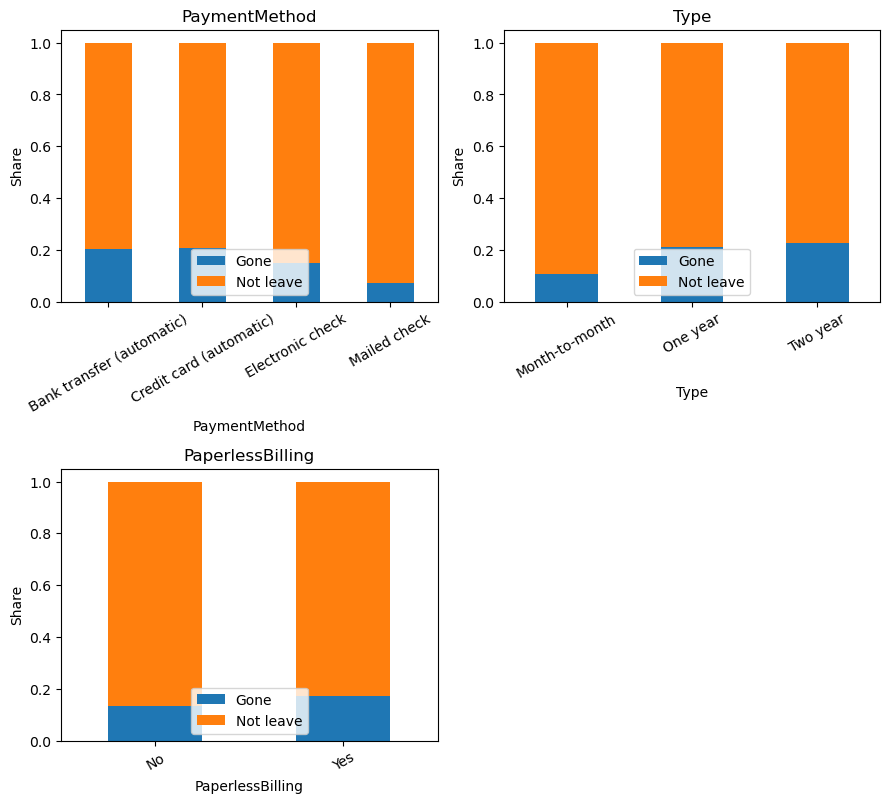

In [34]:
# let's look at the outflow by service, payment type, contract type, invoicing type...
df1=df.copy()
df1['customer_loss'] = df['customer_loss'].replace({1: 'Gone', 0: 'Not leave'})

columns = ['PaymentMethod', 'Type', 'PaperlessBilling']
total_axes = len(columns)
subplt = 1

fig = plt.figure(figsize=(9, 12))
for i in range(len(columns)):
    tmp = df1.pivot_table(index='customer_loss', columns=columns[i], values='Phone', aggfunc='count')
    tmp = tmp.div(tmp.sum(axis=0), axis=1).T
    ax = fig.add_subplot(len(columns), 2, subplt) # add axes for each chart
   #ax.add_table(tmp)
    tmp.plot.bar(stacked=True, rot=30, ax=ax) # draw a graph
    plt.title(columns[i])
    plt.setp(ax.xaxis.get_majorticklabels(), ha='center')
    plt.xlabel(columns[i])
    plt.ylabel('Share')
    plt.legend(loc='lower center') 
    plt.tight_layout()
    subplt+=1

plt.show()
        
del df1, tmp

We see that the largest number of people who left were paid by Bank transfer, Credit card and Electronic check. We also see that almost the same number of clients with the Month-to-month type left and remained in the division by contract type. 

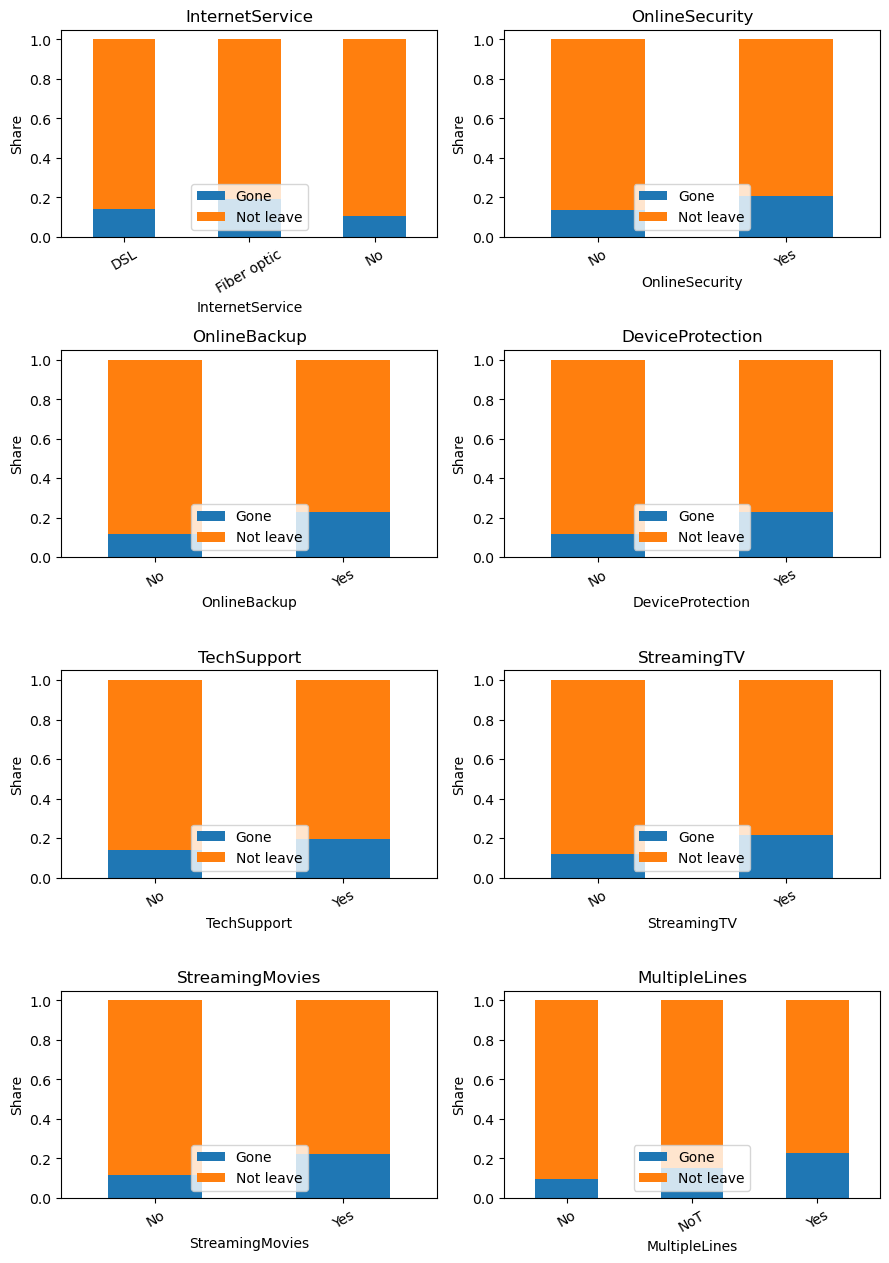

In [35]:
# let's look at the outflow in terms of services InternetService, OnlineSecurity, OnlineBackup, 
## DeviceProtection, TechSupport, StreamingTV, StreamingMovies, MultipleLines
df1=df.copy()
df1['customer_loss'] = df['customer_loss'].replace({1: 'Gone', 0: 'Not leave'})

columns = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
          'StreamingMovies', 'MultipleLines']
total_axes = len(columns)
subplt = 1

fig = plt.figure(figsize=(9, 25))
for i in range(len(columns)):
    tmp = df1.pivot_table(index='customer_loss', columns=columns[i], values='Phone', aggfunc='count')
    tmp = tmp.div(tmp.sum(axis=0), axis=1).T

    
    ax = fig.add_subplot(len(columns), 2, subplt) # add axes for each chart
   #ax.add_table(tmp)
    tmp.plot.bar(stacked=True, rot=30, ax=ax) #  draw a graph
    plt.title(columns[i])
    plt.setp(ax.xaxis.get_majorticklabels(), ha='center')
    plt.xlabel(columns[i])
    plt.ylabel('Share')
    plt.legend(loc='lower center') 
    plt.tight_layout()
    subplt+=1

plt.show()
        
del df1, tmp

The largest number of those who left and those who remained are accounted for by Fiber optic, also the share of the remaining DSLs is catching up with Fiber optic, the smallest number is accounted for by No (those who do not use this service).

Those who did not have the OnlineSecurity service lost twice as many clients. Also, judging by the number of remaining clients, we see that this is not the most popular service. 

The outflow of clients for the OnlineBackup and DeviceProtection services occurred in almost the same proportion for clients who used this service and those who did not. We also see that DeviceProtection is not the most popular service.

TechSupport is also not particularly popular, since a large number of those who left and those who remained did not use it.

StreamingMovies is one and a half times larger than those who do not use it, but at the same time we see that a lot of customers who used it previously have left. 

MultipleLines used a large number of clients, among those who left (almost 2 times more). There are more people who do not use this service.

#### Analysis of customer outflow and inflow by year

In [36]:
# let's display a table with the number of clients who came and left, grouped by year
df1 = df.copy()
# let's create columns with the year the contract began and the year the contract ended
df1['start_year'] = df1['BeginDate'].dt.year
df1['end_year'] = df1['EndDate'].dt.year
# we do not take into account 2020, since we only have information for 1 month
df_st = df1[(df1['end_year'] != 2020)].groupby(['start_year'])['Type'].agg('count').rename('New contract')
df_en = df1[(df1['end_year'] != 2020)].groupby(['end_year'])['Type'].agg('count').rename('Gone')

# display information on the screen
display(pd.concat([df_st, df_en], axis=1).reset_index().rename(columns={'index':'Year'}))
# we will delete the tables since we will no longer use them
del df1, df_st, df_en

,Year,New contract,Gone
0,2013,2,NaN
1,2014,425,7.0
2,2015,272,62.0
3,2016,179,140.0
4,2017,98,235.0
5,2018,66,285.0
6,2019,20,333.0


When analyzing the last three years, we saw a significant increase in incoming clients by approximately 2 times from 2017 to 2019. We also note the increase in those who left, but it is insignificant by about 100 people. from 2017 to 2019, while the share of those who came in relation to those who left exceeded approximately 6 in 2019.

#### Class distribution analysis

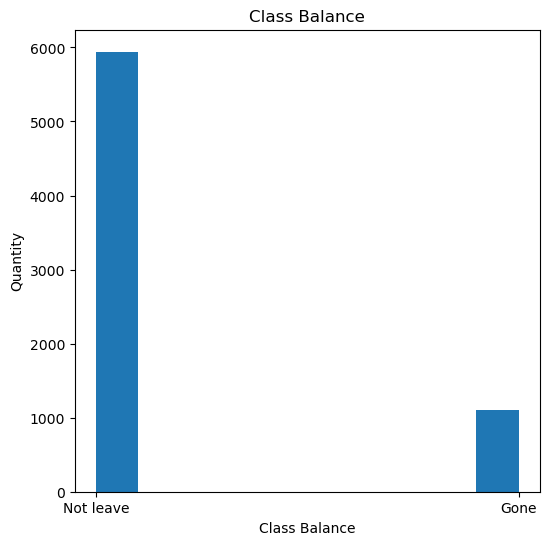

'Class Balance'

customer_loss
Not leave    5942
Gone         1101
Name: customer_loss, dtype: int64

In [37]:
# Let's look at the balance of target trait classes
plt.figure(figsize=(6, 6))
plt.hist((df['customer_loss']).replace({1: 'Gone', 0: 'Not leave'}))
plt.title('Class Balance')
plt.xlabel('Class Balance')
plt.ylabel('Quantity')
plt.show();

display('Class Balance', df.groupby('customer_loss')['customer_loss'].count().rename({1: 'Gone', 0: 'Not leave'}))

The dataset is very unbalanced, the advantage goes to existing clients - 5942 clients.

#### Analysis of the MonthlyCharges column regarding services

In [38]:
# let's look at the table slice MonthlyCharges<20
display(df[df['MonthlyCharges'] <= 20])
display(df[df['MonthlyCharges'] <= 20].groupby('Internet')['Internet'].count())

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,customer_loss,days_total,gender,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Internet,MultipleLines,Phone
customerID,,,,,,,,,,,,,,,,,,,,,
7469-LKBCI,2018-10-01,2020-02-01,Two year,No,Credit card (automatic),18.95,312.30,0,488,Male,...,No,No,No,No,No,No,No,No,No,Yes
1680-VDCWW,2019-02-01,2020-02-01,One year,No,Bank transfer (automatic),19.80,237.60,0,365,Male,...,No,No,No,No,No,No,No,No,No,Yes
2796-NNUFI,2016-04-01,2020-02-01,Two year,Yes,Mailed check,19.95,917.70,0,1401,Female,...,No,No,No,No,No,No,No,No,No,Yes
3679-XASPY,2020-01-01,2020-02-01,Month-to-month,No,Electronic check,19.45,19.45,0,31,Female,...,No,No,No,No,No,No,No,No,No,Yes
2848-YXSMW,2014-02-01,2018-06-01,Two year,No,Credit card (automatic),19.40,1008.80,1,1581,Male,...,No,No,No,No,No,No,No,No,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9588-YRFHY,2016-01-01,2020-02-01,Two year,Yes,Credit card (automatic),19.90,1023.85,0,1492,Male,...,No,No,No,No,No,No,No,No,No,Yes
9364-YKUVW,2018-11-01,2020-02-01,Month-to-month,Yes,Mailed check,19.80,297.00,0,457,Male,...,No,No,No,No,No,No,No,No,No,Yes
3078-ZKNTS,2019-01-01,2020-02-01,Two year,Yes,Bank transfer (automatic),19.75,272.16,0,396,Female,...,No,No,No,No,No,No,No,No,No,Yes


Internet
No    656
Name: Internet, dtype: int64

Clients who have monthly payments below 20 - 656 units. Moreover, upon analysis, we see that these clients have such a low payment because they pay for telephone services and do not have the Internet.

#### Feature correlation

In [39]:
# remove features unsuitable for machine learning BeginDate, EndDate
df = df.drop(['BeginDate', 'EndDate'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   customer_loss     7043 non-null   int32  
 6   days_total        7043 non-null   int64  
 7   gender            7043 non-null   object 
 8   SeniorCitizen     7043 non-null   object 
 9   Partner           7043 non-null   object 
 10  Dependents        7043 non-null   object 
 11  InternetService   7043 non-null   object 
 12  OnlineSecurity    7043 non-null   object 
 13  OnlineBackup      7043 non-null   object 
 14  DeviceProtection  7043 non-null   object 
 15  TechSupport       7043 non-null   object 
 16  StreamingTV       7043 non-null 

In [40]:
# let's build a matrix
phik_review = df.phik_matrix(interval_cols=['MonthlyCharges', 'TotalCharges', 'days_total'])
phik_review.round(2)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,customer_loss,days_total,gender,SeniorCitizen,Partner,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Internet,MultipleLines,Phone
Type,1.00,0.11,0.28,0.39,0.47,0.09,0.63,0.00,0.09,0.18,...,0.51,0.15,0.10,0.14,0.18,0.07,0.07,0.15,0.24,0.00
PaperlessBilling,0.11,1.00,0.37,0.47,0.20,0.08,0.03,0.00,0.24,0.01,...,0.23,0.00,0.20,0.16,0.06,0.34,0.33,0.48,0.10,0.02
PaymentMethod,0.28,0.37,1.00,0.40,0.34,0.21,0.35,0.00,0.29,0.24,...,0.32,0.26,0.28,0.31,0.27,0.38,0.38,0.54,0.17,0.00
MonthlyCharges,0.39,0.47,0.40,1.00,0.71,0.23,0.39,0.01,0.30,0.20,...,0.92,0.55,0.63,0.67,0.58,0.84,0.83,1.00,0.71,0.83
TotalCharges,0.47,0.20,0.34,0.71,1.00,0.30,0.85,0.00,0.14,0.38,...,0.49,0.52,0.62,0.64,0.55,0.64,0.64,0.55,0.47,0.16
customer_loss,0.09,0.08,0.21,0.23,0.30,1.00,0.37,0.01,0.09,0.23,...,0.06,0.13,0.23,0.22,0.10,0.20,0.22,0.11,0.11,0.00
days_total,0.63,0.03,0.35,0.39,0.85,0.37,1.00,0.00,0.06,0.45,...,0.06,0.40,0.41,0.43,0.40,0.34,0.34,0.04,0.35,0.01
gender,0.00,0.00,0.00,0.01,0.00,0.01,0.00,1.00,0.00,0.00,...,0.00,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00
SeniorCitizen,0.09,0.24,0.29,0.30,0.14,0.09,0.06,0.00,1.00,0.02,...,0.16,0.06,0.10,0.09,0.09,0.16,0.19,0.28,0.09,0.00
Partner,0.18,0.01,0.24,0.20,0.38,0.23,0.45,0.00,0.02,1.00,...,0.00,0.22,0.22,0.24,0.19,0.19,0.18,0.00,0.09,0.02


We immediately see a very weak connection between the gender trait. This column can be removed

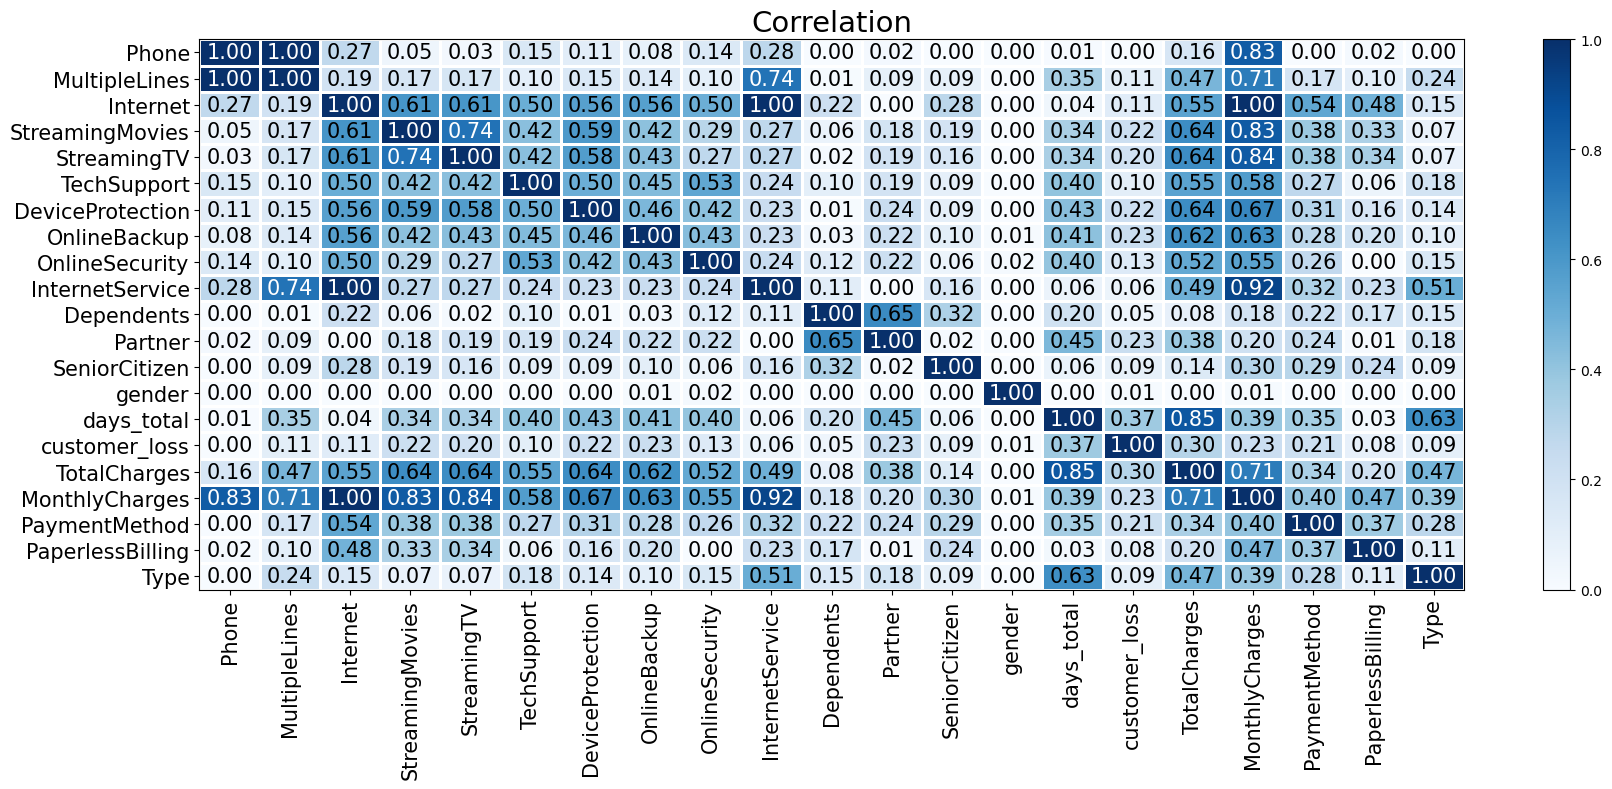

In [41]:
# will build a correlation matrix
plot_correlation_matrix(phik_review.values,
                        x_labels = phik_review.columns, 
                        y_labels = phik_review.index,
                        vmin = 0, vmax = 1,
                        color_map = 'Blues',
                        title = 'Correlation',
                        fontsize_factor = 1.5,
                        figsize = (18, 8))
plt.tight_layout()

Delete the EndDate, BeginDate columns - high correlation with some attributes (customer_loss, day_total) and these columns are not needed, since we created a column with the number of days (days_total)
Remove gender - very weak correlation with all characteristics (tends to zero).
The high multicorrelation of the MonthlyCharges columns with characteristics of Internet-related service types may also need to be removed.

### Conclusion 1 - 3 parts

_______________________________________________________________________________________________________________
We combined the datasets into one single one based on the customerID column; we had gaps in the internet_new and phone_new dataset columns. We entered No in the columns with Internet services, as we found out that these values are missing because clients do not use the Internet. The MultipleLines column was filled with NoT, since No was already used to indicate that clients do not have the ability to connect a telephone set to several lines at the same time.

We also analyzed the outflow of clients regarding services and found out that there are not very popular services like TechSupport. An analysis of customer outflow by contract type showed that a larger number of abandoned customers have a Month-to-month contract, and the departed customers are almost equally distributed by contract type.

Analysis of the class distribution showed that in the customer_loss column there are more customers with 0 (remained) than with 1 (left). 0 - 5942,
1 - 1101. Classes will need to be balanced by specifying the model parameter class_weight = 'balanced', since if the ROC-AUC metric is not sensitive to imbalance, then accuracy will be affected.

Also in this part we looked at the selections in the MonthlyChargec column, which were in the value > 20. Clients have such a low monthly bill because they do not use Internet services and only pay for the phone.

An analysis of the inflow/outflow of clients for 2017-2019 showed that the company’s incoming flow of clients almost doubled in 2019 compared to 2017 and reached 1957, and the outflow increased by only 100 clients - 333. At the same time, the inflow was 6 times more customer churn. 

As a piece of advice, the company can pay attention to customers who do not use the Internet service, but only telephony. You can increase your monthly cash receipts if you sell Internet services to clients, and this is also an additional way to bind a client to you. 

### Building, training, testing the model

#### Preparing the dataset for training

In [42]:
# remove columns from the dataset that will interfere with high-quality training of the model
columns = ['gender', 'Internet', 'Phone', 'MonthlyCharges']
df = df.drop(columns, axis=1)

In [43]:
# display it on the screen
display(df.head())
display(df.info())

,Type,PaperlessBilling,PaymentMethod,TotalCharges,customer_loss,days_total,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,31.04,0,31,No,Yes,No,DSL,No,Yes,No,No,No,No,NoT
5575-GNVDE,One year,No,Mailed check,2071.84,0,1036,No,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,Month-to-month,Yes,Mailed check,226.17,0,123,No,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,One year,No,Bank transfer (automatic),1960.60,0,1371,No,No,No,DSL,Yes,No,Yes,Yes,No,No,NoT
9237-HQITU,Month-to-month,Yes,Electronic check,353.50,0,153,No,No,No,Fiber optic,No,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   TotalCharges      7043 non-null   float64
 4   customer_loss     7043 non-null   int32  
 5   days_total        7043 non-null   int64  
 6   SeniorCitizen     7043 non-null   object 
 7   Partner           7043 non-null   object 
 8   Dependents        7043 non-null   object 
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   object 
 11  OnlineBackup      7043 non-null   object 
 12  DeviceProtection  7043 non-null   object 
 13  TechSupport       7043 non-null   object 
 14  StreamingTV       7043 non-null   object 
 15  StreamingMovies   7043 non-null   object 
 16  MultipleLines     7043 non-null 

None

In [44]:
# let's write down the constants separately
RANDOM_STATE = 2102023

In [45]:
# divide the dataset into training and test samples, ratio 3 to 1
# highlighting features and target features
features = df.drop(['customer_loss'], axis=1)
target = df['customer_loss']
# sampling
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE, stratify=target
)

print(X_train.shape)
print(X_test.shape)

(5282, 16)
(1761, 16)


,customerID
customer_loss,
Gone,0.15638
Not leave,0.84362


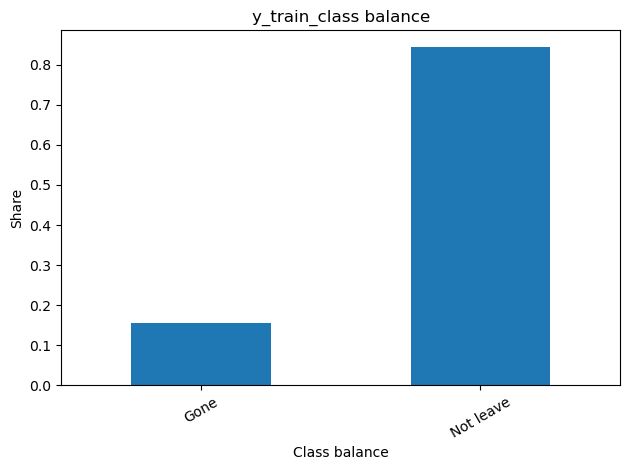

In [46]:
# balance of classes for training set
y_tr = pd.DataFrame([y_train]).T.replace({1: 'Gone', 0: 'Not leave'})
y_tr = y_tr.reset_index()
y_tr = y_tr.pivot_table(index='customer_loss', values='customerID', aggfunc='count')
y_tr = y_tr.div(y_tr.sum(axis=0), axis=1)
display(y_tr)
y_tr.plot.bar(stacked=True, rot=30)
plt.legend('', frameon=False)
plt.title('y_train_class balance')
plt.xlabel('Class balance')
plt.ylabel('Share')
plt.tight_layout()

plt.show()

,customerID
customer_loss,
Gone,0.156161
Not leave,0.843839


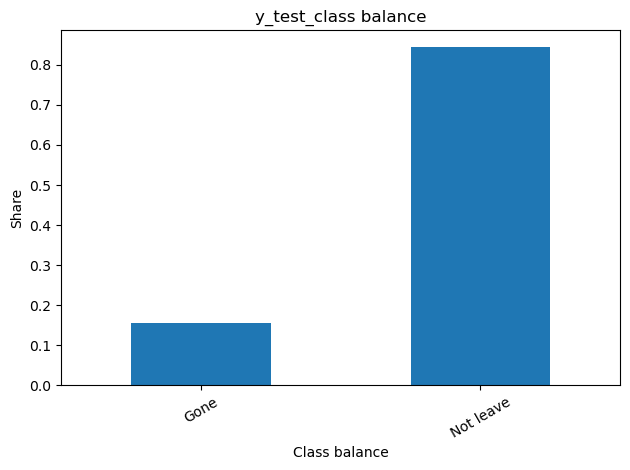

In [47]:
# class balance for test set
y_te = pd.DataFrame([y_test]).T.replace({1: 'Gone', 0: 'Not leave'})
y_te = y_te.reset_index()
y_te = y_te.pivot_table(index='customer_loss', values='customerID', aggfunc='count')
y_te = y_te.div(y_te.sum(axis=0), axis=1)
display(y_te)
y_te.plot.bar(stacked=True, rot=30)
plt.legend('', frameon=False)
plt.title('y_test_class balance')
plt.xlabel('Class balance')
plt.ylabel('Share')
plt.tight_layout()

plt.show()

Identical lobes left and did not leave in both target features

#### Coding, feature scaling, model training

We code and scale, use make_column_transformer and pipeline

In [48]:
# categorical features
category_features = X_train.select_dtypes(include='object').columns.to_list()
print(category_features)

['Type', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']


In [49]:
# numerical features
num_features = X_train.select_dtypes(exclude='object').columns.to_list()
print(num_features)

['TotalCharges', 'days_total']


#### LogisticRegression

In [50]:
%%time
start = time.time()

# let's build a LogisticRegression model using Pipeline


model_lr = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')


param_grid_lr = {'logisticregression__solver': ['lbfgs', 'liblinear', 'sag', 'saga'],
                 'logisticregression__C': [0.1, 500, 0.5]
                }
col_transformer_lr = make_column_transformer((OneHotEncoder(drop='first', handle_unknown='ignore'), category_features),
                                             (StandardScaler(), num_features),
                                             verbose_feature_names_out=False)
pipeline_lr = make_pipeline(col_transformer_lr, model_lr)

gs_lr_pl = GridSearchCV(
    pipeline_lr,
    param_grid=param_grid_lr,
    scoring='roc_auc'
)

gs_lr_pl.fit(X_train, y_train)

gs_lr_best_score = gs_lr_pl.best_score_
gs_lr_best_params = gs_lr_pl.best_params_

# best ROC-AUC value
print(f'best_score: {gs_lr_best_score}')
print(f'best_params: {gs_lr_best_params}')

best_score: 0.75779267121813
best_params: {'logisticregression__C': 0.5, 'logisticregression__solver': 'lbfgs'}
CPU times: total: 9.91 s
Wall time: 4.99 s


#### RandomForestClassifier

In [51]:
%%time
start = time.time()

# let's build a RandomForestClassifier model using Pipeline
model_rf = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')

param_grid_rf = {'randomforestclassifier__n_estimators': range(10, 1000, 200),
                 'randomforestclassifier__max_depth': range(2, 30),
                 'randomforestclassifier__min_samples_split': (1, 100),
                 'randomforestclassifier__min_samples_leaf': (1, 15, 3)
}

col_transformer_rf= make_column_transformer(
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
                                             category_features),
    (RobustScaler(), num_features),
    (PowerTransformer(method='yeo-johnson', standardize=True, copy=False), num_features)
                                            )

pipline_rf = make_pipeline(col_transformer_rf, model_rf)

# use RandomizedSearchCV
gs_rf = RandomizedSearchCV(pipline_rf,
    param_distributions=param_grid_rf,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE)

gs_rf.fit(X_train, y_train)

# best ROC-AUC value
gs_rf_best_score = gs_rf.best_score_
gs_rf_best_params = gs_rf.best_params_

print(f'best_score: {gs_rf_best_score}')
print(f'best_params: {gs_rf_best_params}')

best_score: 0.8241619740204866
best_params: {'randomforestclassifier__n_estimators': 210, 'randomforestclassifier__min_samples_split': 100, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__max_depth': 26}
CPU times: total: 2.45 s
Wall time: 39 s


#### CatBoostClassifier

In [52]:
%%time
start = time.time()

# let's build a CatBoostClassifier model using Pipeline

classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
model_cb = CatBoostClassifier(random_state=RANDOM_STATE, class_weights=class_weights)

param_grid_cb = {
    'catboostclassifier__iterations': [1, 300, 5],
    'catboostclassifier__learning_rate': [0.01, 1, 0.05],
    'catboostclassifier__depth': range(1, 15, 2)}


col_transformer_cb = make_column_transformer(
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
                                             category_features),
    (RobustScaler(), num_features),
    (PowerTransformer(method='yeo-johnson', standardize=True, copy=False), num_features)
                                            )

pipeline_cb = make_pipeline(col_transformer_cb, model_cb)

# use RandomizedSearchCV
gs_cb = GridSearchCV(
    pipeline_cb,
    param_grid=param_grid_cb,
    scoring='roc_auc',
    n_jobs=-1
    
)
gs_cb.fit(X_train, y_train)


# best score ROC-AUC
gs_cb_best_score = gs_cb.best_score_
gs_cb_best_params = gs_cb.best_params_

print(f'best_score: {gs_cb_best_score}')
print(f'best_params: {gs_cb_best_params}')

0:	learn: 0.5921032	total: 144ms	remaining: 43s
1:	learn: 0.5476984	total: 148ms	remaining: 22.1s
2:	learn: 0.5246629	total: 151ms	remaining: 15s
3:	learn: 0.5141600	total: 155ms	remaining: 11.5s
4:	learn: 0.5046465	total: 158ms	remaining: 9.35s
5:	learn: 0.4966784	total: 162ms	remaining: 7.93s
6:	learn: 0.4933176	total: 165ms	remaining: 6.92s
7:	learn: 0.4916506	total: 169ms	remaining: 6.16s
8:	learn: 0.4868128	total: 172ms	remaining: 5.57s
9:	learn: 0.4832161	total: 176ms	remaining: 5.1s
10:	learn: 0.4748349	total: 179ms	remaining: 4.71s
11:	learn: 0.4715624	total: 183ms	remaining: 4.39s
12:	learn: 0.4672366	total: 186ms	remaining: 4.12s
13:	learn: 0.4609142	total: 190ms	remaining: 3.88s
14:	learn: 0.4530367	total: 194ms	remaining: 3.68s
15:	learn: 0.4493388	total: 197ms	remaining: 3.5s
16:	learn: 0.4460389	total: 201ms	remaining: 3.34s
17:	learn: 0.4436764	total: 204ms	remaining: 3.2s
18:	learn: 0.4382782	total: 208ms	remaining: 3.07s
19:	learn: 0.4319942	total: 211ms	remaining: 2.9

209:	learn: 0.1047890	total: 933ms	remaining: 400ms
210:	learn: 0.1044358	total: 937ms	remaining: 395ms
211:	learn: 0.1039022	total: 940ms	remaining: 390ms
212:	learn: 0.1033297	total: 944ms	remaining: 386ms
213:	learn: 0.1029788	total: 948ms	remaining: 381ms
214:	learn: 0.1025730	total: 952ms	remaining: 376ms
215:	learn: 0.1020959	total: 958ms	remaining: 373ms
216:	learn: 0.1018562	total: 962ms	remaining: 368ms
217:	learn: 0.1012983	total: 968ms	remaining: 364ms
218:	learn: 0.1010655	total: 972ms	remaining: 359ms
219:	learn: 0.1006622	total: 976ms	remaining: 355ms
220:	learn: 0.1001402	total: 980ms	remaining: 350ms
221:	learn: 0.0998322	total: 984ms	remaining: 346ms
222:	learn: 0.0995279	total: 988ms	remaining: 341ms
223:	learn: 0.0991049	total: 992ms	remaining: 336ms
224:	learn: 0.0984037	total: 996ms	remaining: 332ms
225:	learn: 0.0977143	total: 1000ms	remaining: 327ms
226:	learn: 0.0972487	total: 1s	remaining: 323ms
227:	learn: 0.0969707	total: 1.01s	remaining: 318ms
228:	learn: 0.

In [53]:
# model selection
result = pd.DataFrame(
    [gs_lr_best_score, gs_rf_best_score, gs_cb_best_score],
    index=['LogisticRegression', 'RandomForestClassifier', 'CatBoostClassifier'],
    columns=['ROC-AUC']
)
result

,ROC-AUC
LogisticRegression,0.757793
RandomForestClassifier,0.824162
CatBoostClassifier,0.894492


At this stage, we identified categorical features ['Type', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport ', 'StreamingTV', 'StreamingMovies', 'MultipleLines'] and numerical characteristics ['TotalCharges', 'days_total'].

We also calculated the class balance on y_target and found out that 0 answers are about 5 times more than 1. Therefore, when training models, we set the parameter class_weight = 'balanced', for CatBoostClasssifier class_weight was set by passing a dictionary with labels and weights, In this way we tried to balance the classes.

Training took place on the trail. models: LogisticRegression, RandomForestClassifier and CatBoostClasssifier. For best_score, the ROC-AUC metric was used. The highest result was shown by the CatBoostClassifier model - 0.89, RandomForestClassifier - 0.82 - in second place, LogisticRegression - 0.76 in third place. 

For testing, we will use CatBoostClassifier, since it showed the highest results, despite the low learning speed. The learning rate is not the main parameter for selecting models.

#### Model testing

In [54]:
%%time
start = time.time()

# let's test the CatBoostClassifier model
rcb_prediction = gs_cb.predict(X_test)
rsb_true_proba = gs_cb.predict_proba(X_test)[:, 1]

# display the metrics accuracy, roc_auc
print('Test accuracy:', accuracy_score(y_test, rcb_prediction))
print("balanced accuracy:", balanced_accuracy_score(y_test, rcb_prediction))
print('Test roc_auc_score:', roc_auc_score(y_test, rsb_true_proba))

Test accuracy: 0.9085746734809768
balanced accuracy: 0.8435898690811208
Test roc_auc_score: 0.9197393857824543
CPU times: total: 109 ms
Wall time: 147 ms


In [55]:
# let's build a ROC curve
def plot_roc_curve(target_test, predicted_test):
    fpr, tpr, thresholds = roc_curve(y_test, predicted_test)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.show()


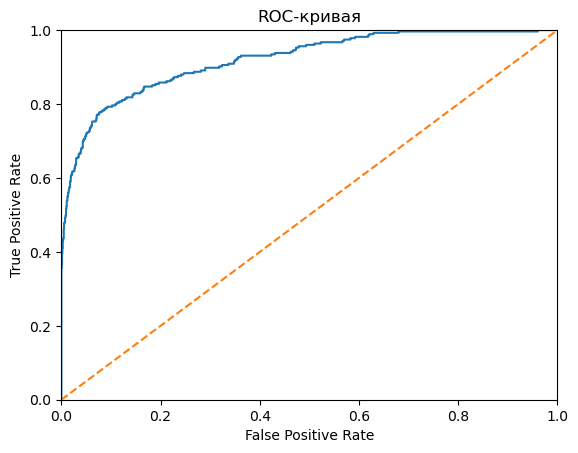

In [56]:
# display it on the screen
plot_roc_curve(y_test, rsb_true_proba)

On the ROC curve graph we see a large area under the Roc curve, which indicates a high forecast tending to 1.

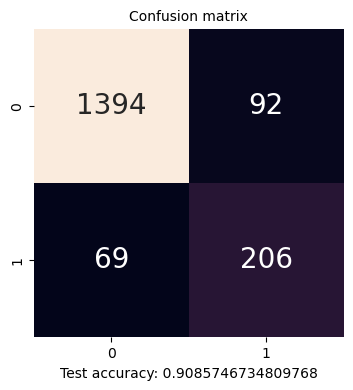

In [57]:
# error matrix
labels = [0, 1]
plt.subplots(figsize=(4, 4))
sns.heatmap(confusion_matrix(y_test, rcb_prediction),
            xticklabels=labels,
            yticklabels=labels,
            annot=True,
            fmt="1.0f",
            cbar=False,
            annot_kws={"size": 20})
plt.title("Confusion matrix", fontsize=10)
plt.xlabel(f"Test accuracy: {accuracy_score(y_test, rcb_prediction)}",
           fontsize=10)
plt.show()

We see that the model makes 92 errors versus 1394 when guessing 0 and 69 out of 206 when guessing 1. In general, the quality is 0.91 - not so high, i.e. out of 100%, the model guesses 91% of the answers. Weak prediction 1 is due to the fact that there are much fewer clients who left in the dataset than those who remained.

It is possible to increase the quality of metrics by expanding the data with additional information, for example: the client’s place of residence, loyal/disloyal (degree of loyalty or whether they would recommend to friends), etc., e.g., carry out client profiling

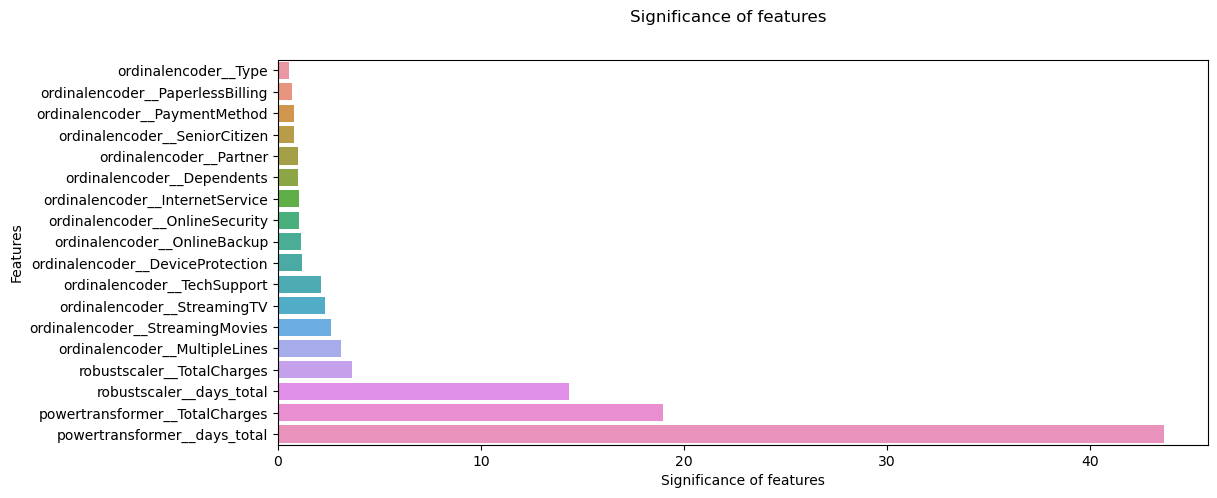

In [58]:
# feature significance graph:
fig, ax = plt.subplots(figsize=(12, 5))
fig.suptitle('Significance of features')

sns.barplot(y=gs_cb.best_estimator_[:-1].get_feature_names_out(),
            x=np.sort(gs_cb.best_estimator_[-1].feature_importances_),
            ax=ax)
ax.set(xlabel="Significance of features", ylabel='Features');



In the graph, the features are sorted from least to most important. The significant attribute is days_total, and next in significance is TotalCharges. We also see that Type and PaperlessBilling have no weight in the prediction.

### Report

# **Goal, objectives, signs**

<u>*Purpose of the project work*</u> - create a machine learning model that predicts customer departure, the ROC-AUC of which should be greater than 0.85.

During the work we completed the following <u>*tasks*</u>:

1. conduct initial research of datasets
2. consolidate datasets into a single table
3. analyze customer churn regarding the services provided
4. highlight the target feature
5. see correlation of features
6. prepare the dataset for model training
7. write model code and train models
9. calculate ROC-AUC on the training model
10. write conclusions
11. select a model with a result greater than 0.85 (if this is not the case, return to feature preparation)
12. test the selected model
13. calculate accuracy and ROC-AUC
14. analyze the error matrix and the importance of features
15. write a report, give recommendations

Worked with the following <u>*datasets and features*</u>:
- personal_new.csv
    - gender - пол
    - SeniorCitizen
    - Partner
    - Dependents
- contract_new.csv
    - BeginDate - contract start date
    - EndDate - contract end date
    - Type - contract type: monthly, annual, etc.
    - PaperlessBilling - invoicing by email
    - PaymentMethod - payment method
    - MonthlyCharges - monthly expenses for services
    - TotalCharges - total money spent on services
- internet_new.csv
    - InternetService - availability of Internet services
    - OnlineSecurity - firewall
    - OnlineBackup - cloud file storage for data backup
    - DeviceProtection - antivirus
    - TechSupport - dedicated technical support line
    - StreamingTV - online TV
    - StreamingMovies - online cinema
- phone_new.csv
    - MultipleLines - ability to connect a telephone to several lines simultaneously
    
The work proceeded strictly according to the points of the plan. 

#### **Description of the main stages of work**

##### **Introduction to Datasets**

After getting acquainted with 4 datasets, we see that at first glance there are no missing values in any of them. The datasets have different numbers of lines: contract and personal each contain 7043 lines, phone_new - 6361 lines, internet_new - 5517 lines. The reason is the different number of lines - contract and personal contain information about all clients, internet_new and phone-new only those who use this type of service. Almost all dataset columns contain data of the object type. A common column for tables is customerID.

In the contract dataset, we converted the values of the BeginingData and EndData columns to the datetime type, and the values of the TotalCharges column to the float type. Added a customer_loss column with a target variable, where 1 - the customer has left, 0 - the customer cooperates with the company. We added a days_total column for subsequent analysis, which represents the number of days of cooperation between the client and the company. We found out that in the TotalCharges column the minimum value is 0 for those clients who joined the company on 02/01/2020, and there are also high numbers (7400 - 8000) for clients who have been working with the company for more than 5 years. We also saw high values around < 20 for the MonthlyCharges column. We analyzed it at stage 3. Analysis of the combined dataset in terms of services and found out that the monthly accrual is low due to the fact that clients only use the telephone and do not use the Internet.

##### **Analysis of the combined dataset**

Next, we combined them into a single dataset and conducted additional analysis on the full dataset. We filled in the missing values in the columns of the internet_new phone_new datasets, since initially these datasets contained fewer rows than contract and personal. For the internet_new columns we filled in 'No', for the phone_new column we used the third value NoT (no telephone), since 'No' was used to indicate the possibility/impossibility of connecting a telephone set to several lines at the same time.

Analyzed customer outflow regarding services. An analysis of customer outflow by contract type showed that a larger number of remaining customers have a Month-to-month contract, and departed customers are almost equally distributed by contract type. An analysis of the inflow/outflow of clients for 2017-2019 showed that the company’s incoming flow of clients increased almost 2 times in 2019 compared to 2017 and reached 1957, and the outflow increased by only 100 clients - 333. At the same time, the inflow was 6 times more customer churn.
  
We correlated the features by building a correlation matrix, having previously removed the columns that were not suitable for machine learning - 'BeginDate', 'EndDate'. Also, based on the correlation matrix, we removed the following columns: 'gender', 'Internet', 'Phone' - with a weak correlation and 'MonthlyCharges' - with a very strong correlation.

As a piece of advice, the company can pay attention to customers who do not use the Internet service, but only telephony. You can increase your monthly cash receipts if you sell Internet services to clients, and this is also an additional way to bind a client to you.
  
##### **Machine learning**

During training, we used the following models: LogisticRegression, RandomForestClassifier and CatBoostClasssifier. For best_score, the ROC-AUC metric was used. To balance classes when training models, we set the parameter class_weight = 'balanced', for CatBoostClasssifier class_weight was set by passing a dictionary with labels and weights, so we tried to balance the classes. The highest result was shown by the CatBoostClassifier model - 0.92, RandomForestClassifier - 0.83 - in second place, LogisticRegression - 0.76 in third place. For testing, we took CatBoostClassifier, which showed a high ROC-AUC. 
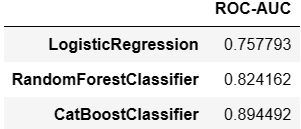

The target attribute is customer_loss. We also identified numerical and categorical features. For numerical ones we went - TotalCharges, for categorical ones - 'Type', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', ' TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines'.

It is also worth noting that we encoded OneHotEncoder of categorical features in LogisticRegsssion, OrdinalEncoder in RandomForestClassifier and CatBoostClassifier. StandardScaler was used to scale numerical features.

##### **Model testing**

The metrics we displayed when testing the model were ROC-AUC and accuracy. On the test sample, the model showed the following results: accuracy: 0.91, roc_auc_score: 0.92. Accuracy is not high enough and means that out of 100%, the model correctly guessed 91% of the answers regarding the set of test target features. Also on the ROC curve graph we see a large area under the Roc curve, which indicates a high forecast tending to 1.

The error matrix shows that there is still room for improvement and improvement of the model, since the model makes 92 errors versus 1394 when guessing 0 and 69 out of 206 when guessing 1.
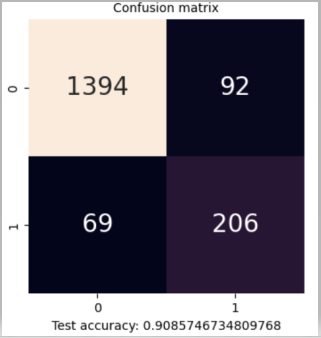

Of the set of attributes, the most important are days_total, and next in importance is TotalCharges. We also see that Type and PaperlessBilling have no weight in the prediction.

#### **Recommendations**

As recommendations, it will increase the quality of the metrics by possibly expanding the data with additional information, for example: the client’s place of residence, loyal\disloyal (degree of loyalty or whether they would recommend to friends), etc. perhaps what promotions were carried out for the client, i.e. carry out client profiling. 

At the stage of trial operation, together with marketers, select the classification threshold so as to optimize not the machine learning metric, but business metrics in monetary terms, taking into account the still unknown budget for customer retention campaigns and the different costs of errors of the first and second types.

The goal of getting ROC-AUC above 0.85 has been completed. The goal of creating a machine learning model to predict customer churn is accomplished.